In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용 - 리눅스 사용할때
import scipy
import scipy.stats as stats

import os
import re
import time
import datetime as dt # 사용시 datetime.dt 로 사용 # 현재 시간 사용
from datetime import datetime # 사용시 함수로 바로 사용 #-> 시간 비교

In [2]:
### 한글 폰트 설치 - 윈도우 사용할 때
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

path = 'c:/Windows/Fonts/malgun.ttf'  # 또는 나눔고딕: 'c:/Windows/Fonts/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

In [3]:
# 경고창 무시
import warnings
warnings.filterwarnings('ignore')

## 데이터 전처리

In [4]:
df_heart = pd.read_csv("../../dataset/heart_2020_cleaned.csv")
df_heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [5]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [6]:
# 결측값 확인
df_heart.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [7]:
# 이상치 확인 (# BMI: BMI 수치, # PhysicalHealth, MentalHealth: 날짜, SleepTime : 수면시간)
df_heart.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


<Axes: ylabel='BMI'>

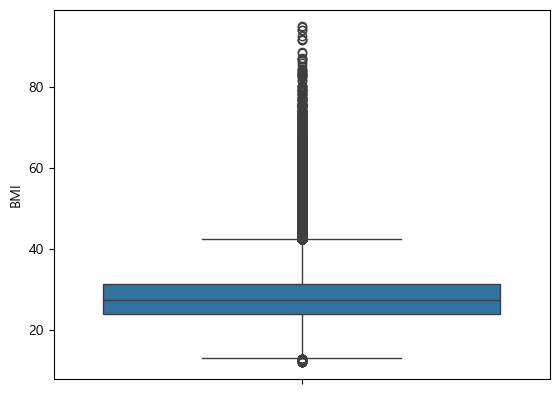

In [8]:
# bmi 컬럼에서 비현실적인 수치가 존재
sns.boxplot(data = df_heart["BMI"])

In [9]:
# BMI 사분위수를 이용한 이상치 제거
Q1 = 24.030000
Q3 = 31.420000
IQR = Q3-Q1
print(f"(1) Q1-1.5*IQR 값 : {Q1-1.5*IQR}")
print(f"(2) Q3+1.5*IQR 값 : {Q3+1.5*IQR}")

condition_bmi = f"{Q1-1.5*IQR} <= BMI <= {Q3+1.5*IQR}"

(1) Q1-1.5*IQR 값 : 12.945
(2) Q3+1.5*IQR 값 : 42.505


In [10]:
# 개인 판단 건강정도 - 평균을 기준으로 판단
df_heart["PhysicalHealth"].mean(),df_heart["MentalHealth"].mean()

(3.3717100017198516, 3.898366140808956)

In [11]:
# BMI 기준 정의
def classify_bmi(bmi):
    if bmi < 18.5:
        return '저체중'
    elif 18.5 <= bmi <= 24.9:
        return '정상 체중'
    elif 25 <= bmi <= 29.9:
        return '과체중'
    elif 30 <= bmi <= 34.9:
        return '경도 비만'
    elif 35 <= bmi <= 39.9:
        return '중도 비만'
    else:
        return '고도 비만'

# Sleeping 기준 정의
def classify_sleep(hours):
    if hours < 6:
        return '불면증'
    elif 6 <= hours <= 9:
        return '정상'
    else:
        return '과다 수면'

# 신체 건강 정도 범주화
def classify_physical(value):
    if value < 3.24:
        return '나쁨'
    else:
        return '좋음'

# 정신 건강 정도 범주화
def classify_mental(value):
    if value < 3.80:
        return '나쁨'
    else:
        return '좋음'

# 나이 범주화
def classify_age_category(age_range):
    if age_range in ['18-24']:
        return '청소년기'
    elif age_range in ['25-29', '30-34', '35-39', '40-44', '45-49']:
        return '청년기'
    elif age_range in ['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']:
        return '노년기'

# bmi 이상치 제거(df_heart_stable 생성)
df_heart_stable = df_heart.query(condition_bmi)

df_heart_stable['BMI'] = df_heart_stable['BMI'].apply(classify_bmi)
df_heart_stable['SleepTime'] = df_heart_stable['SleepTime'].apply(classify_sleep)
df_heart_stable['PhysicalHealth'] = df_heart_stable['PhysicalHealth'].apply(classify_physical)
df_heart_stable['MentalHealth'] = df_heart_stable['MentalHealth'].apply(classify_mental)
df_heart_stable['AgeCategory'] = df_heart_stable['AgeCategory'].apply(classify_age_category)

In [12]:
df_heart_yes = df_heart_stable.query("HeartDisease == 'Yes'")
df_heart_no = df_heart_stable.query("HeartDisease == 'No'")

## 데이터 시각화
- 목적 :  각 컬럼별 심장병 유무 지표 확인

### (1) BMI 

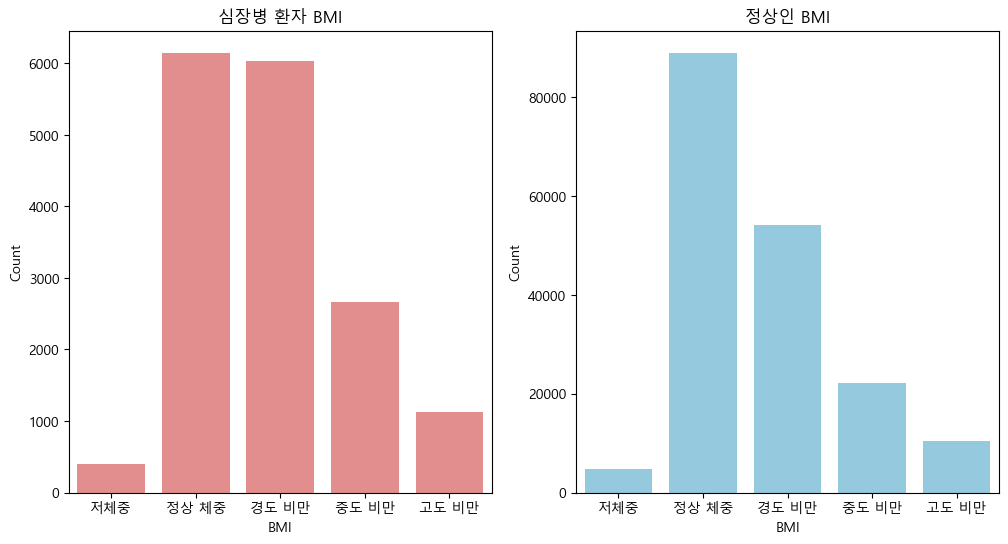

<Figure size 640x480 with 0 Axes>

In [13]:
# orders 설정
orders = ['저체중', '정상 체중', '경도 비만', '중도 비만', '고도 비만']

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='BMI', order=orders, color='lightcoral')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('심장병 환자 BMI')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='BMI', order=orders, color='skyblue')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('정상인 BMI')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (2) 흡연

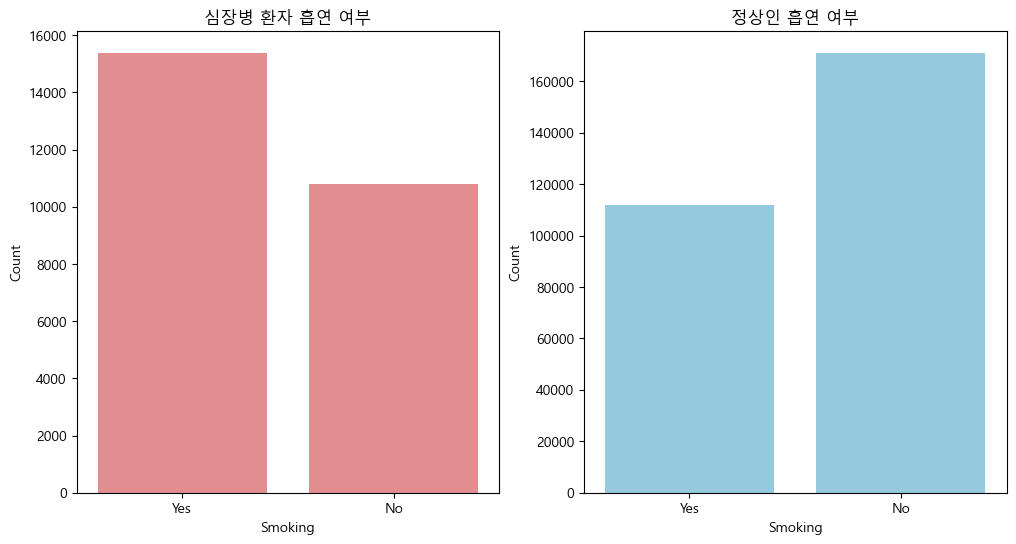

<Figure size 640x480 with 0 Axes>

In [14]:
# orders 설정
orders = ["Yes","No"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='Smoking', order=orders, color='lightcoral')
plt.xlabel('Smoking')
plt.ylabel('Count')
plt.title('심장병 환자 흡연 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='Smoking', order=orders, color='skyblue')
plt.xlabel('Smoking')
plt.ylabel('Count')
plt.title('정상인 흡연 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (3) 음주 여부

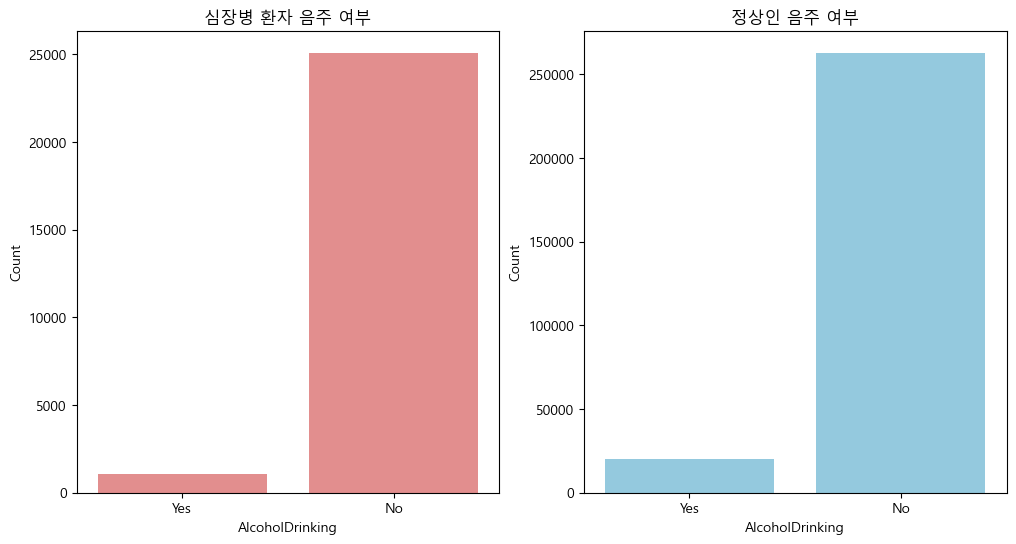

<Figure size 640x480 with 0 Axes>

In [15]:
# orders 설정
orders = ["Yes","No"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='AlcoholDrinking', order=orders, color='lightcoral')
plt.xlabel('AlcoholDrinking')
plt.ylabel('Count')
plt.title('심장병 환자 음주 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='AlcoholDrinking', order=orders, color='skyblue')
plt.xlabel('AlcoholDrinking')
plt.ylabel('Count')
plt.title('정상인 음주 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (4) 뇌졸증 여부

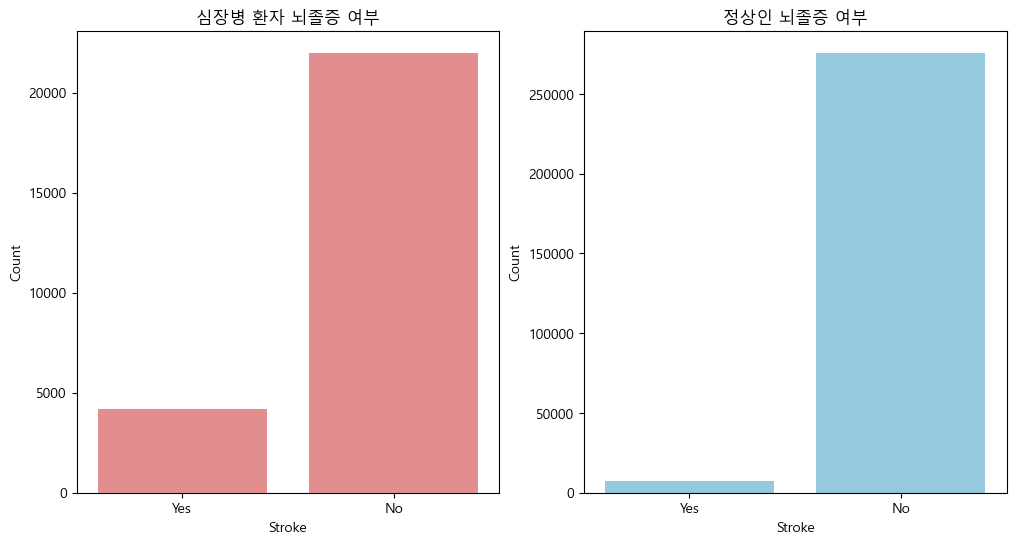

<Figure size 640x480 with 0 Axes>

In [16]:
# orders 설정
orders = ["Yes","No"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='Stroke', order=orders, color='lightcoral')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('심장병 환자 뇌졸증 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='Stroke', order=orders, color='skyblue')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('정상인 뇌졸증 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (5) 신체적 건강

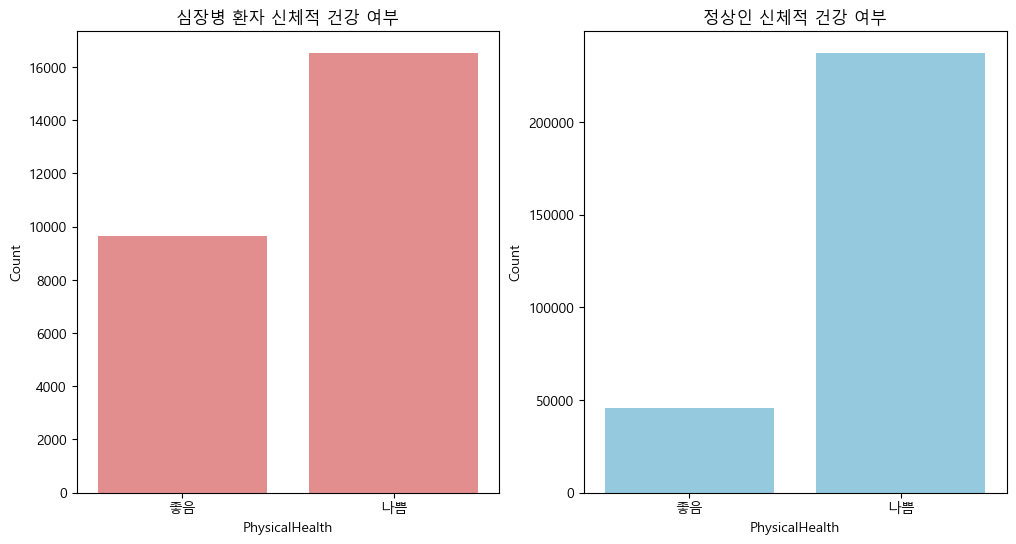

<Figure size 640x480 with 0 Axes>

In [17]:
# orders 설정
orders = ["좋음","나쁨"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='PhysicalHealth', order=orders, color='lightcoral')
plt.xlabel('PhysicalHealth')
plt.ylabel('Count')
plt.title('심장병 환자 신체적 건강 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='PhysicalHealth', order=orders, color='skyblue')
plt.xlabel('PhysicalHealth')
plt.ylabel('Count')
plt.title('정상인 신체적 건강 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (6) 정신적 건강

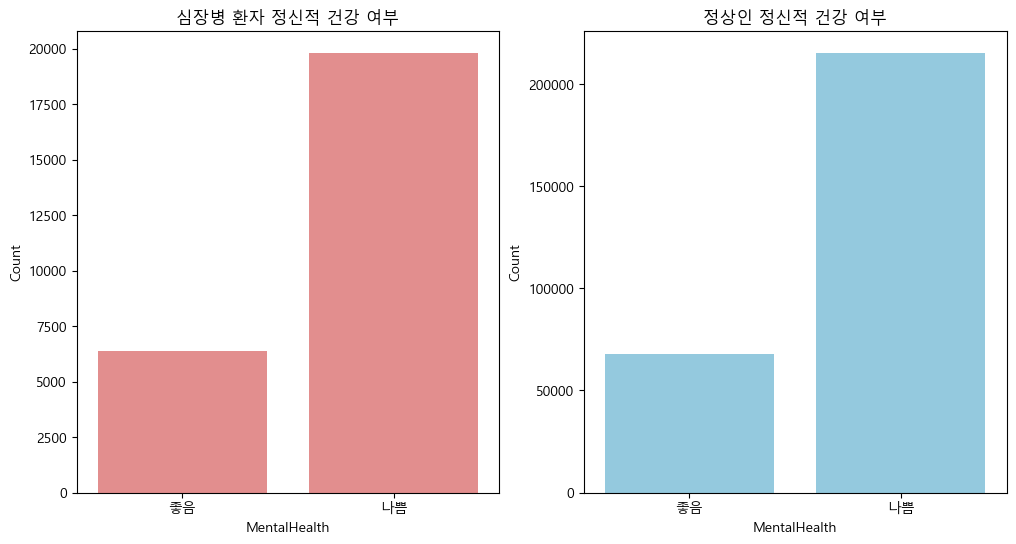

<Figure size 640x480 with 0 Axes>

In [18]:
# orders 설정
orders = ["좋음","나쁨"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='MentalHealth', order=orders, color='lightcoral')
plt.xlabel('MentalHealth')
plt.ylabel('Count')
plt.title('심장병 환자 정신적 건강 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='MentalHealth', order=orders, color='skyblue')
plt.xlabel('MentalHealth')
plt.ylabel('Count')
plt.title('정상인 정신적 건강 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (7) 보행 시 어려움 여부

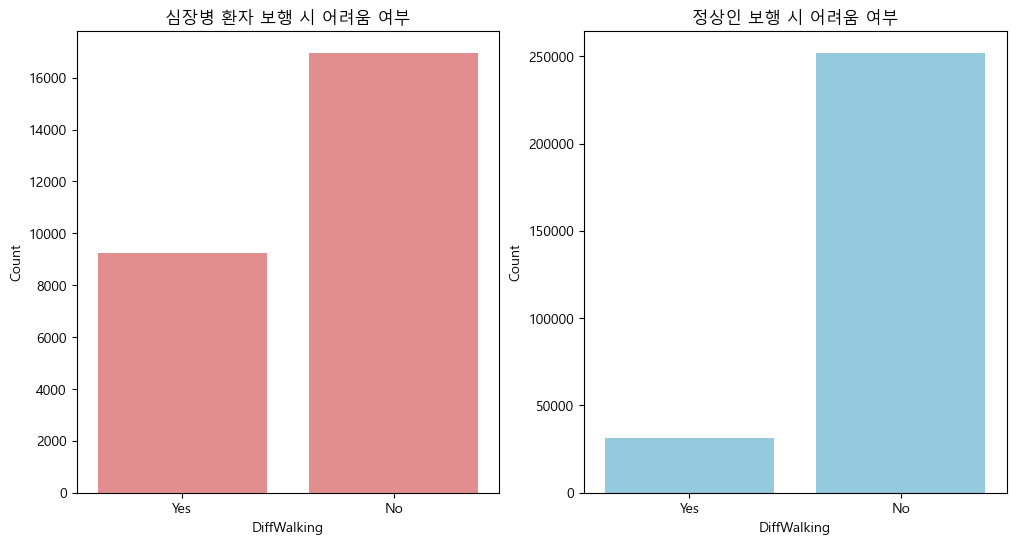

<Figure size 640x480 with 0 Axes>

In [19]:
# orders 설정
orders = ["Yes","No"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='DiffWalking', order=orders, color='lightcoral')
plt.xlabel('DiffWalking')
plt.ylabel('Count')
plt.title('심장병 환자 보행 시 어려움 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='DiffWalking', order=orders, color='skyblue')
plt.xlabel('DiffWalking')
plt.ylabel('Count')
plt.title('정상인 보행 시 어려움 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (8) 성별

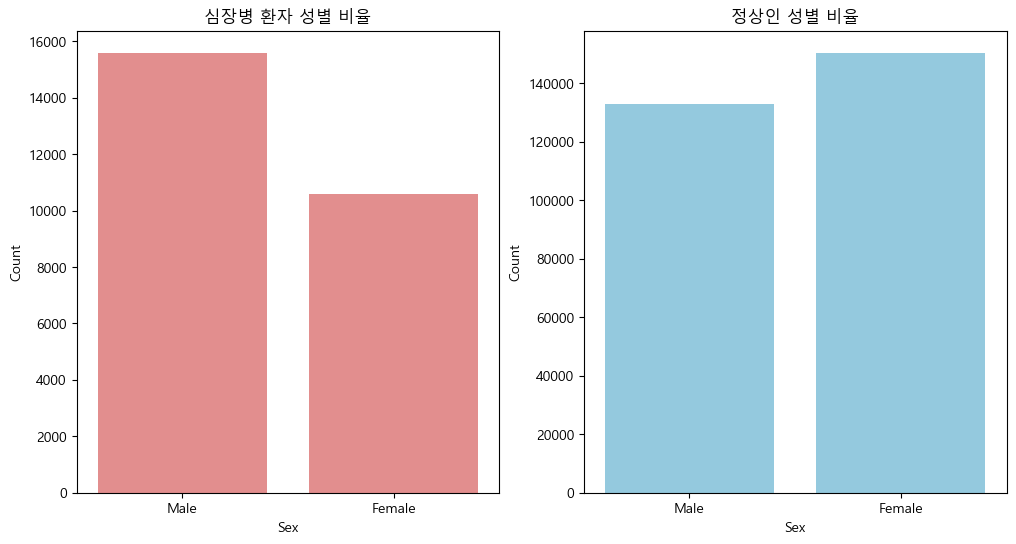

<Figure size 640x480 with 0 Axes>

In [20]:
# orders 설정
orders = ["Male","Female"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='Sex', order=orders, color='lightcoral')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('심장병 환자 성별 비율')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='Sex', order=orders, color='skyblue')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('정상인 성별 비율')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (9) 연령대

In [21]:
df_heart_yes["AgeCategory"].unique()

array(['노년기', '청년기', '청소년기'], dtype=object)

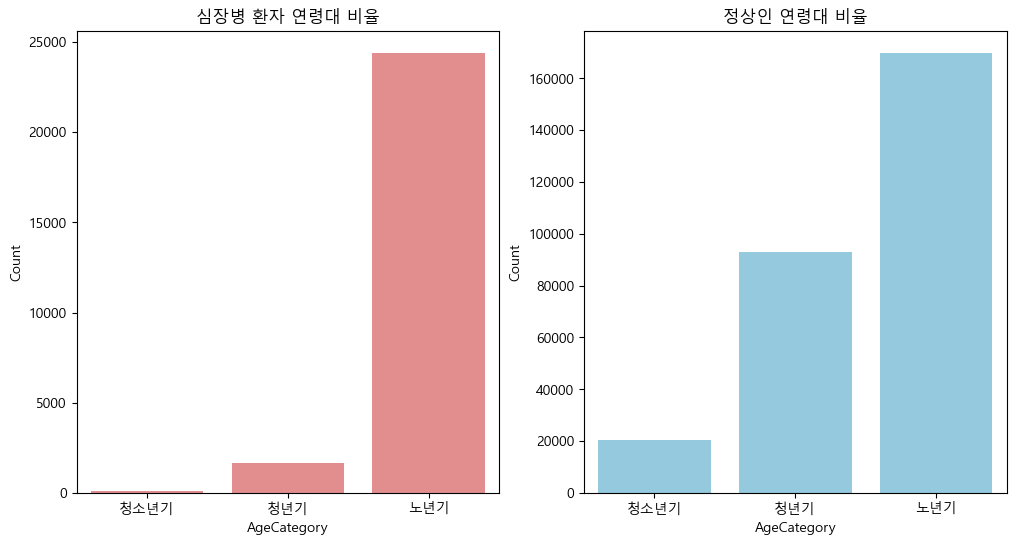

<Figure size 640x480 with 0 Axes>

In [22]:
# orders 설정
orders = ["청소년기","청년기","노년기"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='AgeCategory', order=orders, color='lightcoral')
plt.xlabel('AgeCategory')
plt.ylabel('Count')
plt.title('심장병 환자 연령대 비율')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='AgeCategory', order=orders, color='skyblue')
plt.xlabel('AgeCategory')
plt.ylabel('Count')
plt.title('정상인 연령대 비율')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (10) 인종

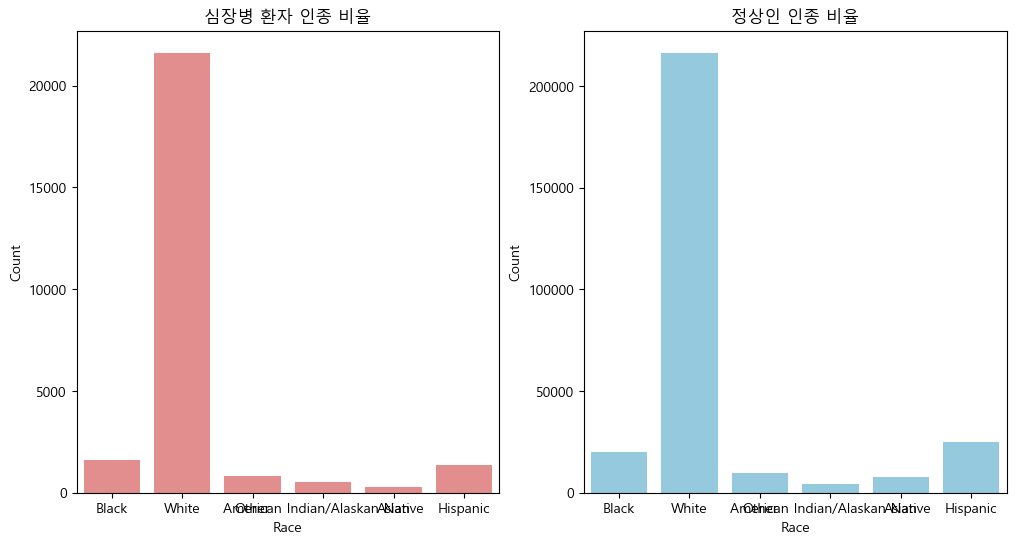

<Figure size 640x480 with 0 Axes>

In [23]:
# orders 설정
orders = list(df_heart_yes["Race"].unique())

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='Race', order=orders, color='lightcoral')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('심장병 환자 인종 비율')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='Race', order=orders, color='skyblue')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('정상인 인종 비율')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (11) 당뇨병 여부

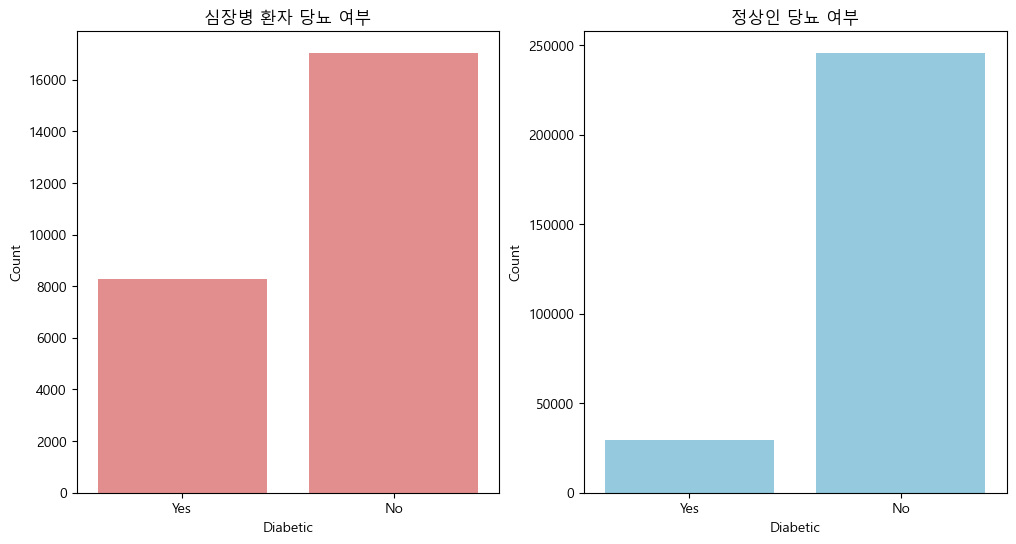

<Figure size 640x480 with 0 Axes>

In [24]:
# orders 설정
orders = ["Yes","No"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='Diabetic', order=orders, color='lightcoral')
plt.xlabel('Diabetic')
plt.ylabel('Count')
plt.title('심장병 환자 당뇨 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='Diabetic', order=orders, color='skyblue')
plt.xlabel('Diabetic')
plt.ylabel('Count')
plt.title('정상인 당뇨 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (12) 신체 활동

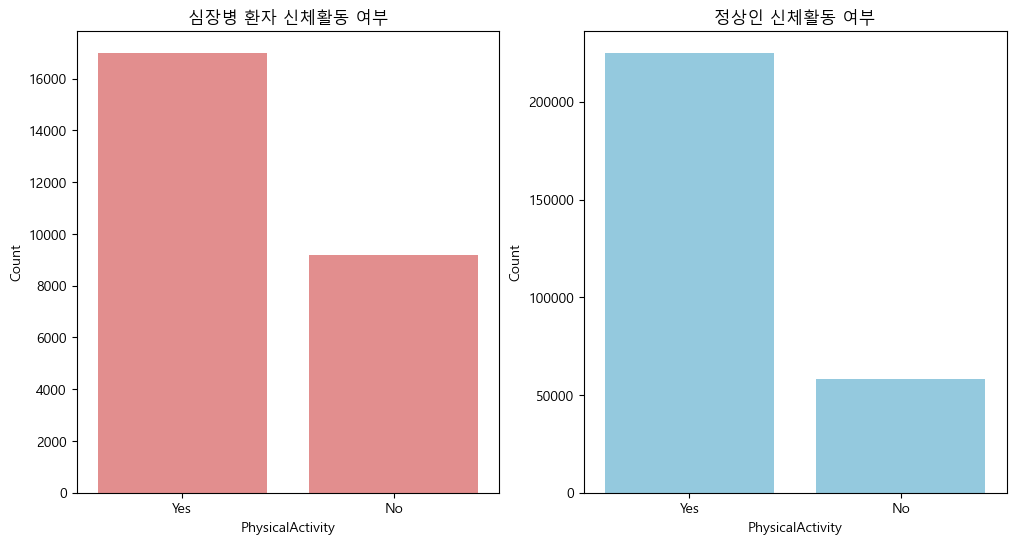

<Figure size 640x480 with 0 Axes>

In [25]:
# orders 설정
orders = ["Yes","No"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='PhysicalActivity', order=orders, color='lightcoral')
plt.xlabel('PhysicalActivity')
plt.ylabel('Count')
plt.title('심장병 환자 신체활동 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='PhysicalActivity', order=orders, color='skyblue')
plt.xlabel('PhysicalActivity')
plt.ylabel('Count')
plt.title('정상인 신체활동 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (13) 주관적 건강상태

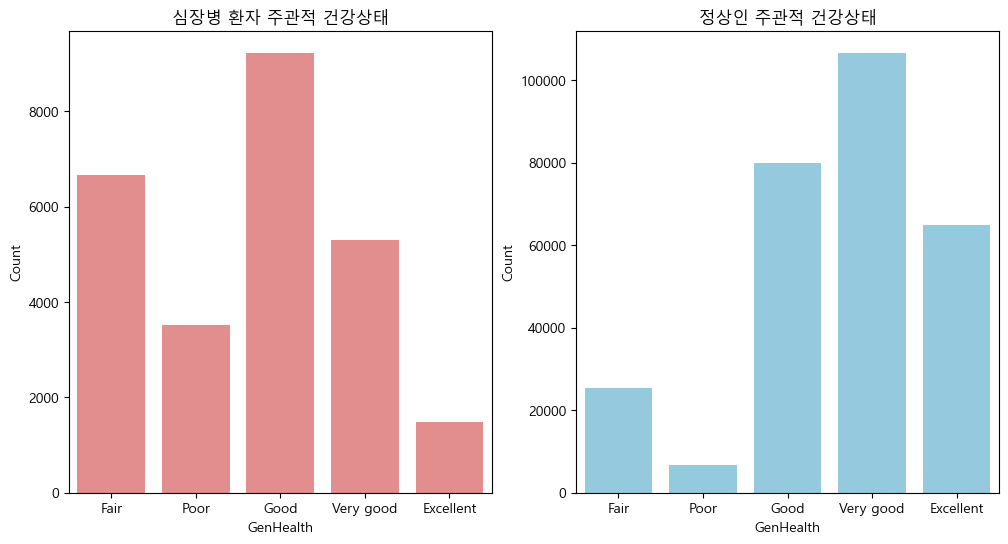

<Figure size 640x480 with 0 Axes>

In [26]:
# orders 설정
orders = list(df_heart_yes['GenHealth'].unique())

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='GenHealth', order=orders, color='lightcoral')
plt.xlabel('GenHealth')
plt.ylabel('Count')
plt.title('심장병 환자 주관적 건강상태')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='GenHealth', order=orders, color='skyblue')
plt.xlabel('GenHealth')
plt.ylabel('Count')
plt.title('정상인 주관적 건강상태')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (14) 수면시간

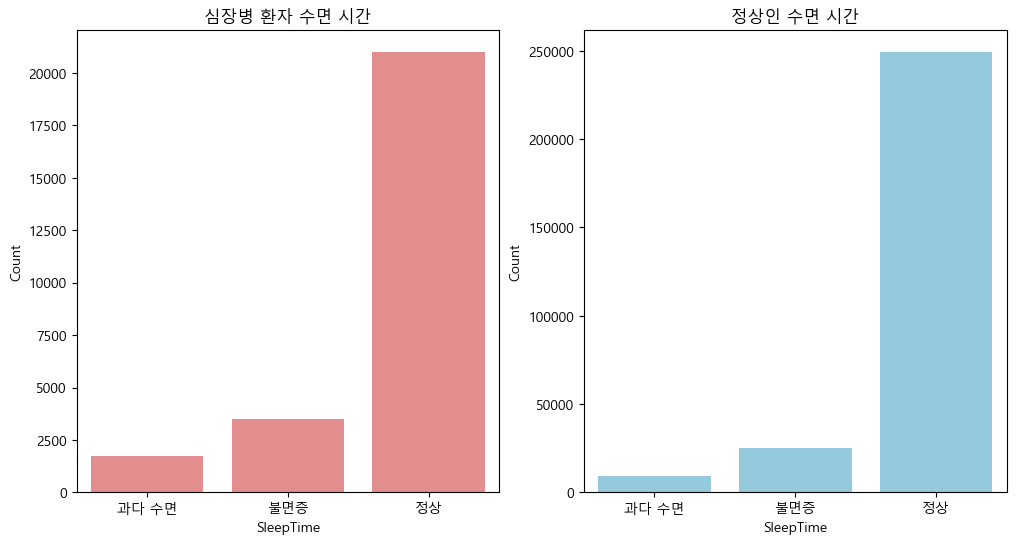

<Figure size 640x480 with 0 Axes>

In [27]:
# orders 설정
orders = list(df_heart_yes['SleepTime'].unique())

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='SleepTime', order=orders, color='lightcoral')
plt.xlabel('SleepTime')
plt.ylabel('Count')
plt.title('심장병 환자 수면 시간')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='SleepTime', order=orders, color='skyblue')
plt.xlabel('SleepTime')
plt.ylabel('Count')
plt.title('정상인 수면 시간')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (15) 천식 여부

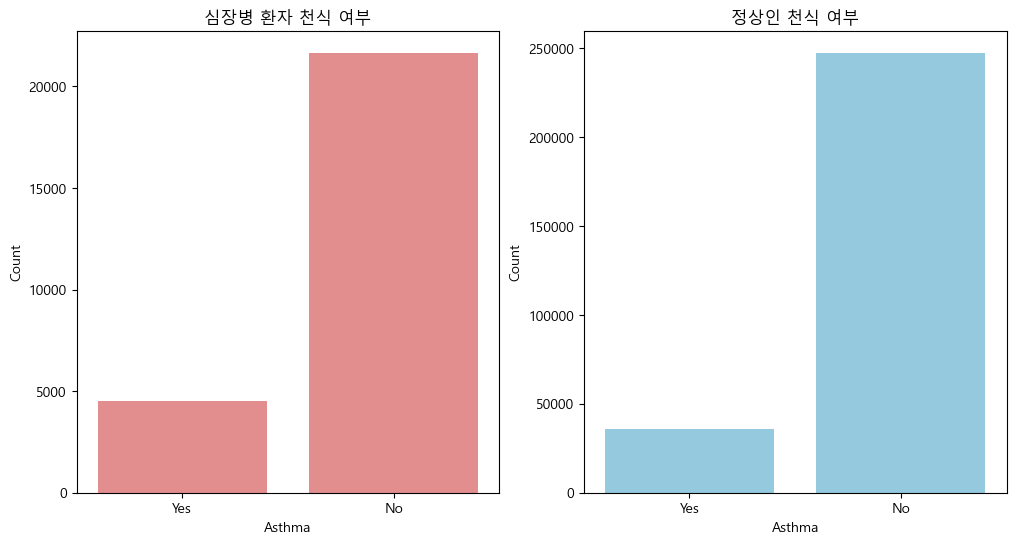

<Figure size 640x480 with 0 Axes>

In [28]:
# orders 설정
orders = ["Yes","No"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='Asthma', order=orders, color='lightcoral')
plt.xlabel('Asthma')
plt.ylabel('Count')
plt.title('심장병 환자 천식 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='Asthma', order=orders, color='skyblue')
plt.xlabel('Asthma')
plt.ylabel('Count')
plt.title('정상인 천식 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (16) 신장병 여부

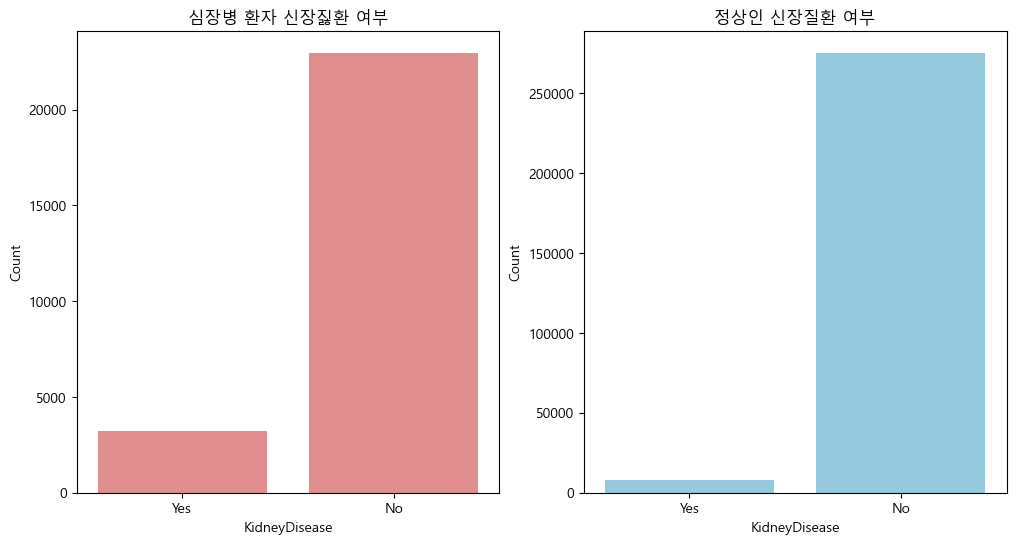

<Figure size 640x480 with 0 Axes>

In [31]:
# orders 설정
orders = ["Yes","No"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='KidneyDisease', order=orders, color='lightcoral')
plt.xlabel('KidneyDisease')
plt.ylabel('Count')
plt.title('심장병 환자 신장짏환 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='KidneyDisease', order=orders, color='skyblue')
plt.xlabel('KidneyDisease')
plt.ylabel('Count')
plt.title('정상인 신장질환 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

### (17) 피부암 여부

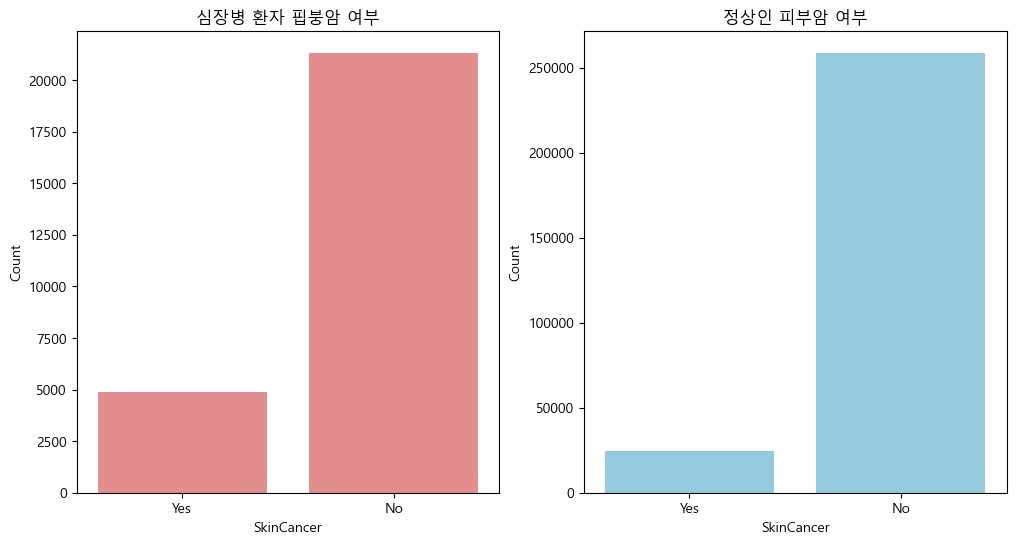

<Figure size 640x480 with 0 Axes>

In [30]:
# orders 설정
orders = ["Yes","No"]

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 심장병 환자
plt.subplot(1, 2, 1)
sns.countplot(data=df_heart_yes, x='SkinCancer', order=orders, color='lightcoral')
plt.xlabel('SkinCancer')
plt.ylabel('Count')
plt.title('심장병 환자 핍붕암 여부')

# 정상인
plt.subplot(1, 2, 2)
sns.countplot(data=df_heart_no, x='SkinCancer', order=orders, color='skyblue')
plt.xlabel('SkinCancer')
plt.ylabel('Count')
plt.title('정상인 피부암 여부')
plt.show()

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

## 데이터 시각화 결과
